In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import glob
import numpy as np
import seaborn as sns

In [10]:
file_paths = sorted(glob.glob('./train_eval_out_10_nosim_wheldout/fold_*/fold_*_classification_scores_forTestSet_trainedWithTrainingSet.xls'))

In [11]:
file_paths[:5]

['./train_eval_out_10_nosim_wheldout/fold_0/fold_0_classification_scores_forTestSet_trainedWithTrainingSet.xls',
 './train_eval_out_10_nosim_wheldout/fold_1/fold_1_classification_scores_forTestSet_trainedWithTrainingSet.xls',
 './train_eval_out_10_nosim_wheldout/fold_2/fold_2_classification_scores_forTestSet_trainedWithTrainingSet.xls',
 './train_eval_out_10_nosim_wheldout/fold_3/fold_3_classification_scores_forTestSet_trainedWithTrainingSet.xls',
 './train_eval_out_10_nosim_wheldout/fold_4/fold_4_classification_scores_forTestSet_trainedWithTrainingSet.xls']

In [12]:
# Get Seaborn's colorblind-friendly palette
colors = sns.color_palette("colorblind")
# Create a mapping for consistent use across data
label_color_dict = {
    'seqSVM_score': colors[0],
    'seqDNN_score': colors[1],
    'ProteinBERT_score': colors[2],
    'seqSVM_seqDNN_score': colors[3],
    'seqSVM_seqDNN_ProteinBERT_score': colors[4],
}

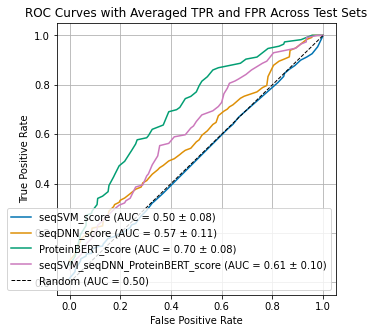

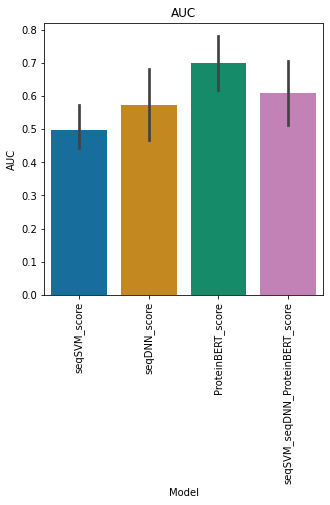

In [13]:


# File paths

model_metrics = {}

# Process each file
for file_path in file_paths:
    # Load data
    df =pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Extract true labels and model scores
    y_true = df['RBP_flag']  # Convert 0=True, 1=False to binary labels
    for model in df.columns[1:]:  # Exclude 'Protein_RBP_flag'
        y_scores = df[model]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores,pos_label=1)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics for each model
        if model not in model_metrics:
            model_metrics[model] = {'fpr': [], 'tpr': [], 'auc': []}
        model_metrics[model]['fpr'].append(fpr)
        model_metrics[model]['tpr'].append(tpr)
        model_metrics[model]['auc'].append(roc_auc)

# Average TPR and FPR across test sets for each model
average_metrics = {}
for model, metrics in model_metrics.items():
    # Interpolate TPR at a common set of FPR points for averaging
    all_fpr = np.unique(np.concatenate(metrics['fpr']))
    mean_tpr = np.zeros_like(all_fpr)
    for fpr, tpr in zip(metrics['fpr'], metrics['tpr']):
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= len(metrics['fpr'])

    # Compute mean and std AUC
    mean_auc = np.mean(metrics['auc'])
    std_auc = np.std(metrics['auc'])

    # Store averaged metrics
    average_metrics[model] = {
        'mean_fpr': all_fpr,
        'mean_tpr': mean_tpr,
        'mean_auc': mean_auc,
        'std_auc': std_auc
    }

# Plot ROC curves with mean and standard deviation
plt.figure(figsize=(5, 5))
for model, metrics in average_metrics.items():
    if model in ['seqSVM_score', 'seqDNN_score', 'ProteinBERT_score','seqSVM_seqDNN_ProteinBERT_score']:
        mean_fpr = metrics['mean_fpr']
        mean_tpr = metrics['mean_tpr']
        mean_auc = metrics['mean_auc']
        std_auc = metrics['std_auc']
        
        plt.plot(mean_fpr, mean_tpr, label=f'{model} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',color=label_color_dict[model])
        # plt.fill_between(mean_fpr, 
        #                  np.maximum(mean_tpr - std_auc, 0), 
        #                  np.minimum(mean_tpr + std_auc, 1), 
        #                  alpha=0.2)


plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with Averaged TPR and FPR Across Test Sets')
plt.legend(loc='lower right')
plt.grid()
#plt.show()
plt.savefig('hydra_cv-AUC_10_nosim_wheldout.png')
plt.savefig('hydra_cv-AUC_10_nosim_wheldout.svg')
plt.savefig('hydra_cv-AUC_10_nosim_wheldout.jpg')
plt.show()

plt.figure(figsize=(5, 5))

auc_scores = []
model_x = []
for k in ['seqSVM_score', 'seqDNN_score', 'ProteinBERT_score','seqSVM_seqDNN_ProteinBERT_score']:
#for k in average_metrics:
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc'])
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc']-average_metrics[k]['std_auc'])
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc']+average_metrics[k]['std_auc'])
df_model_plot = pd.DataFrame({'Model': model_x, 'AUC': auc_scores})
# Plot using the full color dictionary
sns.barplot(x='Model', y='AUC', data=df_model_plot, palette=label_color_dict)
plt.title('AUC')
plt.xticks(rotation=90)
plt.savefig('hydra_cv-ROC_10_nosim_wheldout.png')
plt.savefig('hydra_cv-ROC_10_nosim_wheldout.svg')
plt.savefig('hydra_cv-ROC_10_nosim_wheldout.jpg')

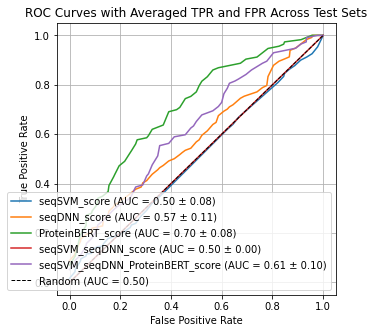

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'seqSVM_score'),
  Text(1, 0, 'seqDNN_score'),
  Text(2, 0, 'ProteinBERT_score'),
  Text(3, 0, 'seqSVM_seqDNN_score'),
  Text(4, 0, 'seqSVM_seqDNN_ProteinBERT_score')])

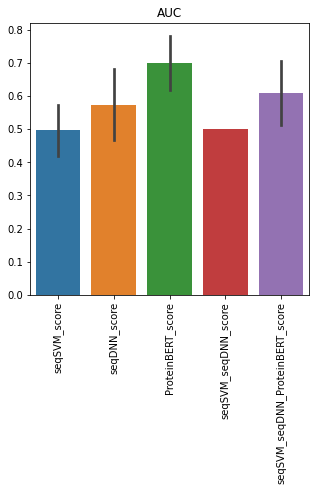

In [14]:

model_metrics = {}

# Process each file
for file_path in file_paths:
    # Load data
    df =pd.read_csv(file_path, sep='\t', index_col=0)
    
    # Extract true labels and model scores
    y_true = df['RBP_flag']  # Convert 0=negative, 1=positive to binary labels
    for model in df.columns[1:]:  # Exclude 'Protein_RBP_flag'
        y_scores = df[model]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores,pos_label=1)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics for each model
        if model not in model_metrics:
            model_metrics[model] = {'fpr': [], 'tpr': [], 'auc': []}
        model_metrics[model]['fpr'].append(fpr)
        model_metrics[model]['tpr'].append(tpr)
        model_metrics[model]['auc'].append(roc_auc)

# Average TPR and FPR across test sets for each model
average_metrics = {}
for model, metrics in model_metrics.items():
    # Interpolate TPR at a common set of FPR points for averaging
    all_fpr = np.unique(np.concatenate(metrics['fpr']))
    mean_tpr = np.zeros_like(all_fpr)
    for fpr, tpr in zip(metrics['fpr'], metrics['tpr']):
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= len(metrics['fpr'])

    # Compute mean and std AUC
    mean_auc = np.mean(metrics['auc'])
    std_auc = np.std(metrics['auc'])

    # Store averaged metrics
    average_metrics[model] = {
        'mean_fpr': all_fpr,
        'mean_tpr': mean_tpr,
        'mean_auc': mean_auc,
        'std_auc': std_auc
    }

# Plot ROC curves with mean and standard deviation
plt.figure(figsize=(5, 5))
for model, metrics in average_metrics.items():
    #if model in ['seqSVM_score', 'seqDNN_score', 'PPI_score', 'PIA_score', 'ProteinBERT_score', 'seqSVM_seqDNN_ProteinBERT_score']:
    mean_fpr = metrics['mean_fpr']
    mean_tpr = metrics['mean_tpr']
    mean_auc = metrics['mean_auc']
    std_auc = metrics['std_auc']
    
    plt.plot(mean_fpr, mean_tpr, label=f'{model} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    # plt.fill_between(mean_fpr, 
    #                  np.maximum(mean_tpr - std_auc, 0), 
    #                  np.minimum(mean_tpr + std_auc, 1), 
    #                  alpha=0.2)


plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves with Averaged TPR and FPR Across Test Sets')
plt.legend(loc='lower right')
plt.grid()
#plt.show()
# plt.savefig('hydra_cv-ROC_nosim_wheldout.png')
# plt.savefig('hydra_cv-ROC_nosim_wheldout.svg')
# plt.savefig('hydra_cv-ROC_nosim_wheldout.jpg')
plt.show()

plt.figure(figsize=(5, 5))

auc_scores = []
model_x = []
for k in average_metrics:
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc'])
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc']-average_metrics[k]['std_auc'])
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc']+average_metrics[k]['std_auc'])
sns.barplot(x=model_x, y=auc_scores)
plt.title('AUC')
plt.xticks(rotation=90)
# plt.savefig('hydra_cv-AUC_ROC_nosim_wheldout.png')
# plt.savefig('hydra_cv-AUC_ROC_nosim_wheldout.svg')
# plt.savefig('hydra_cv-AUC_ROC_nosim_wheldout.jpg')

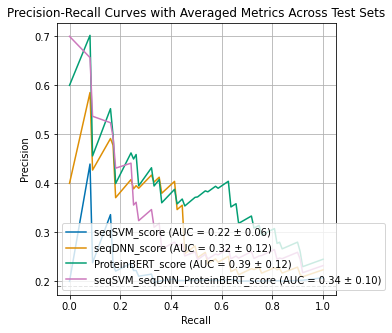

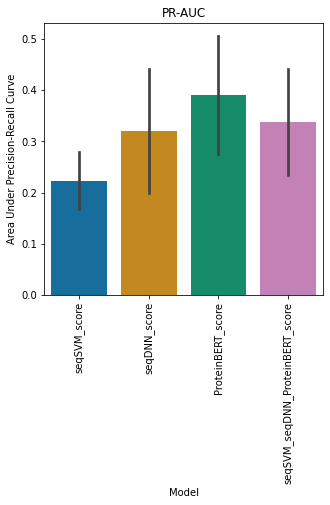

In [8]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# File paths
model_metrics = {}

# Process each file
for file_path in file_paths:
    # Load data
    df = pd.read_csv(file_path, sep='\t', index_col=0)

    # Extract true labels
    y_true = df['RBP_flag']
    
    for model in df.columns[1:]:  # Exclude 'RBP_flag'
        #print(model)
        y_scores = df[model]

        #Skip if model column has invalid values like -1
        if (y_scores < 0).any():
            #print(sum(y_scores <0))
            continue
        
        # Compute PR curve and AUC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)

        # Store metrics
        if model not in model_metrics:
            model_metrics[model] = {'precision': [], 'recall': [], 'auc': []}
        model_metrics[model]['precision'].append(precision)
        model_metrics[model]['recall'].append(recall)
        model_metrics[model]['auc'].append(pr_auc)

# Average PR curves across folds for each model
average_metrics = {}
for model, metrics in model_metrics.items():
    # Interpolate precision at a common set of recall points for averaging
    all_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(all_recall)
    for precision, recall in zip(metrics['precision'], metrics['recall']):
        mean_precision += np.interp(all_recall, recall[::-1], precision[::-1])  # reverse to make recall increasing
    mean_precision /= len(metrics['precision'])

    mean_auc = np.mean(metrics['auc'])
    std_auc = np.std(metrics['auc'])

    average_metrics[model] = {
        'mean_recall': all_recall,
        'mean_precision': mean_precision,
        'mean_auc': mean_auc,
        'std_auc': std_auc
    }

# Plot Precision-Recall curves
plt.figure(figsize=(5, 5))
for model, metrics in average_metrics.items():
    #if model in ['seqSVM_score', 'seqDNN_score', 'ProteinBERT_score', 'seqSVM_seqDNN_ProteinBERT_score']:
    mean_recall = metrics['mean_recall']
    mean_precision = metrics['mean_precision']
    mean_auc = metrics['mean_auc']
    std_auc = metrics['std_auc']
    
    plt.plot(mean_recall, mean_precision, label=f'{model} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',color=label_color_dict[model])
    # plt.fill_between(mean_recall,
    #                  np.maximum(mean_precision - std_auc, 0),
    #                  np.minimum(mean_precision + std_auc, 1),
    #                  alpha=0.2)


#plt.figure(figsize=(5, 5))
plt.axhline(y=0.19, linestyle='--', lw=1, color='grey')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves with Averaged Metrics Across Test Sets')
plt.legend(loc='lower left')
plt.grid()
#plt.tight_layout()
plt.savefig('hydra_cv-PRC_10_ROC_nosim_wheldout.png')
plt.savefig('hydra_cv-PRC_10_ROC_nosim_wheldout.svg')
plt.savefig('hydra_cv-PRC_10_ROC_nosim_wheldout.jpg')
plt.show()

# Bar plot of average PR-AUCs
plt.figure(figsize=(5, 5))
auc_scores = []
model_x = []
for k in ['seqSVM_score', 'seqDNN_score', 'ProteinBERT_score', 'seqSVM_seqDNN_ProteinBERT_score']:
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc'])
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc']-average_metrics[k]['std_auc'])
    model_x.append(k)
    auc_scores.append(average_metrics[k]['mean_auc']+average_metrics[k]['std_auc'])
df_model_plot = pd.DataFrame({'Model': model_x, 'AUC': auc_scores})
# Plot using the full color dictionary
sns.barplot(x='Model', y='AUC', data=df_model_plot, palette=label_color_dict)
plt.title('PR-AUC')
plt.ylabel('Area Under Precision-Recall Curve')
plt.xticks(rotation=90)
plt.savefig('hydra_cv-PRAUC_10_ROC_nosim_wheldout.png')
plt.savefig('hydra_cv-PRAUC_10_ROC_nosim_wheldout.svg')
plt.savefig('hydra_cv-PRAUC_10_ROC_nosim_wheldout.jpg')
plt.show()
